# **Raport Symulacje Komputerowe**
## Autorzy: Zofia Polak 276220, Filip Miśkiewicz 276007, Malwina Olszewska 276019

In [ ]:
import math
import time
import timeit
import typing

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.special import lambertw


# Ustawienia graficzne wykresów

In [ ]:
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"]="--"

# Zadanie 1

Celem zadania było zaimplementowanie generatora liczb pseudolosowych ACORN. W rozwiązaniu umieściliśmy dwie metody realizacji algorytmu, aby porównać ich efektywność oraz zwracane rezultaty.

In [ ]:
def acorn(N:int, k:int=9, M:int=2**89-1, lag:int=1000, X0_0:int=314159265359) -> np.array:
    """ Creates acorn random number generator.

    Parameters:
    N(int)
    k(int)
    M(int) - (default 2**89 - 1)
    lag(int) - (default 1000)
    X0_0(int) - (default 314159265359)

    Returns:
    np.array[float] - array of numbers generated by acorn.

    Example:
    >>> acorn(10)
    array([], dtype=float64)
    """
    X = np.zeros((k+1, N+1), dtype=float)
    X[0, :] = X0_0
    for i in range(1, k+1):
        for j in range(1, N+1):
            X[i, j] = (X[i-1, j] + X[i, j-1]) % M

    Yk_n = X[k-1, 1:][lag:] / float(M)
    return Yk_n

In [ ]:
def acorn2(N:int, k:int=9, M:int=2**89-1, lag:int=1000, X0_0:int=314159265359) -> np.array:
    """ Creates acorn random number generator. It is a faster implementation of the acorn() function.

    Parameters:
    N(int)
    k(int)
    M(int) - (default 2**89 - 1)
    lag(int) - (default 1000)
    X0_0(int) - (default 314159265359)

    Returns:
    array[float] - array of numbers generated by acorn.

    Example:
    >>> acorn2(10)
    array([], dtype=float64)
    """
    mod_sum = np.frompyfunc(lambda X1, X2: (X1 + X2) % M, 2, 1)
    X = np.zeros((k+1, N+1), dtype=float)
    X[0, :] = X0_0
    for i in range(1, k+1):
        X[i, 1:] += X[i-1, 1:]
        X[i, 1:] = mod_sum.accumulate(X[i, 1:])

    Yk_n = X[k-1, 1:][lag:] / float(M)
    return Yk_n

#### Sprawdzamy czy implementacje dają takie same wyniki.

In [ ]:
N = 10000
params1 = {"k": 9, "lag": 1000, "X0_0": 123456789}
params2 = {"k": 2, "lag": 1234, "X0_0": 987654321}
params3 = {"k": 5, "lag": 10,   "X0_0": 100000001}

assert (acorn(1000, **params1) == acorn2(1000, **params1)).all()
assert (acorn(1000, **params2) == acorn2(1000, **params2)).all()
assert (acorn(1000, **params3) == acorn2(1000, **params3)).all()

Następnie rysujemy wykresy kolejnych wartości $Y_n$ w zależności od parametru $k$.

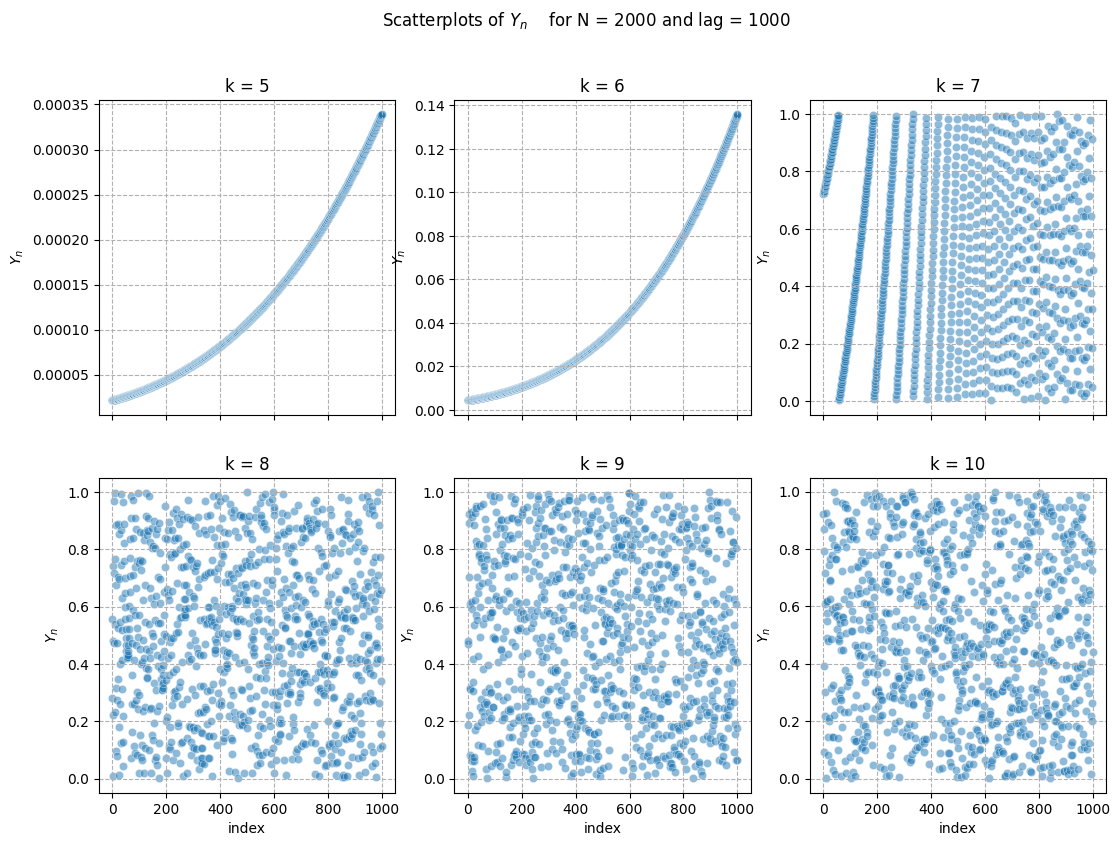

In [ ]:
ks = [5, 6, 7, 8, 9, 10]
fig, axes = plt.subplots(2, 3, figsize=(13,9), sharex=True,)
N = 2000
lag = 1000
plt.suptitle("Scatterplots of $Y_{n} \quad $" + f" for N = {N} and lag = {lag}")
for i, ax in enumerate(axes.ravel()):
    Y = acorn2(N, k=ks[i], lag=1000)
    sns.scatterplot(ax=ax, x=range(len(Y)), y=Y, alpha=0.5)
    ax.set_title(f"k = {ks[i]}")
    ax.set_ylabel("$Y_n$")
    ax.set_xlabel("index")
    # ax.set_xlim(0, 1)

#### W tym miejscu badamy czy istnieje zależność między poprzednimi wyrazami ciągu.

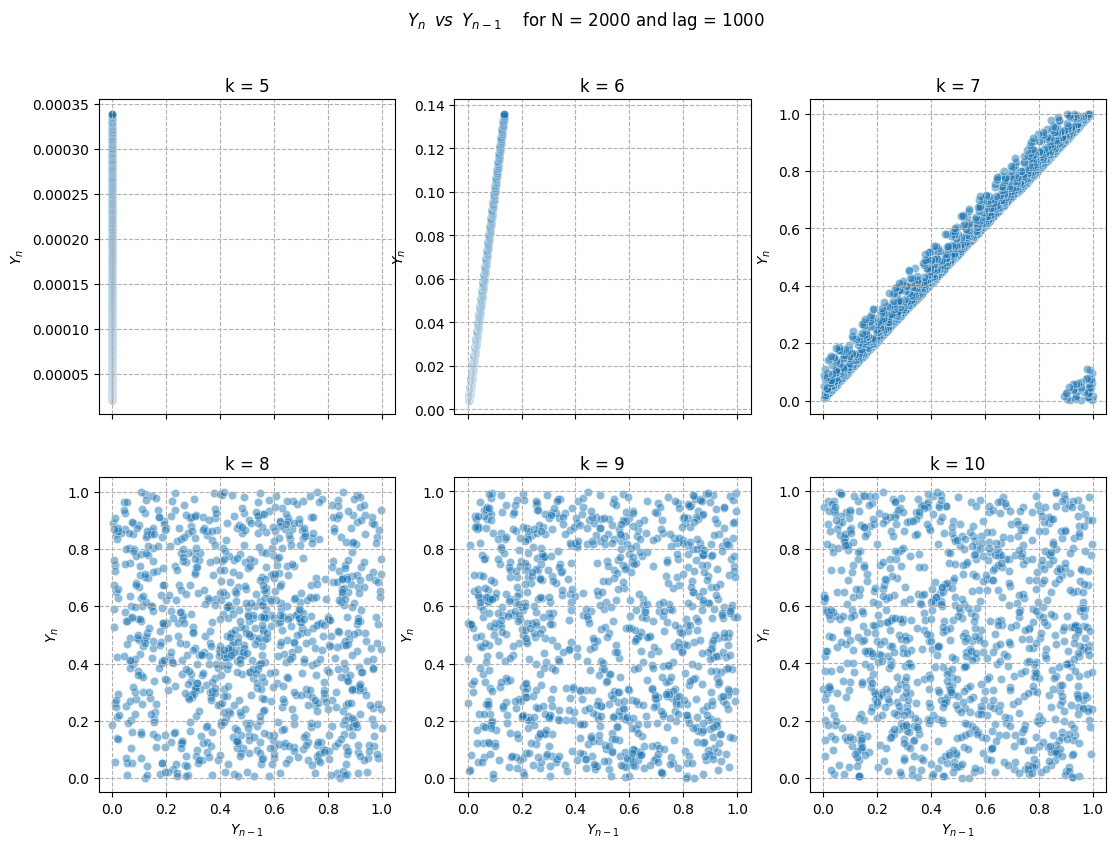

In [ ]:
ks = [5, 6, 7, 8, 9, 10]
fig, axes = plt.subplots(2, 3, figsize=(13,9), sharex=True)
N = 2000
Lag = 1000
plt.suptitle("$Y_{n} \;\;vs\;\; Y_{n-1} \quad $" + f" for N = {N} and lag = {lag}")
plt.grid(linestyle="--")
for i, ax in enumerate(axes.ravel()):
    Y = acorn2(N, k=ks[i], lag=1000)
    sns.scatterplot(ax=ax, x=Y[:-1], y=Y[1:], alpha=0.5)
    ax.set_title(f"k = {ks[i]}")
    ax.set_ylabel("$Y_n$")
    ax.set_xlabel("$Y_{n-1}$")
    # ax.set_xlim(0, 1)


Widzimy, że dla $k < 8$, znając wartość wyrazu $Y_{n-1}$ jesteśmy w stanie z dużym prawdopodobieństwem estymować wartość $Y_n$, zatem w tych przypadkach, ciąg nie przypomina ciągu zmiennych losowych IID z rozkładu $U(0,1)$. Dla większych wartości parametru $k$ obserwujemy, że rozkład wygląda na znacznie bardziej zbliżony do jednostajnego. Aby z większą dokładnością ocenić czy rozkład przypomina $U(0,1)$ generujemy histogramy przyjmowanych wartości.

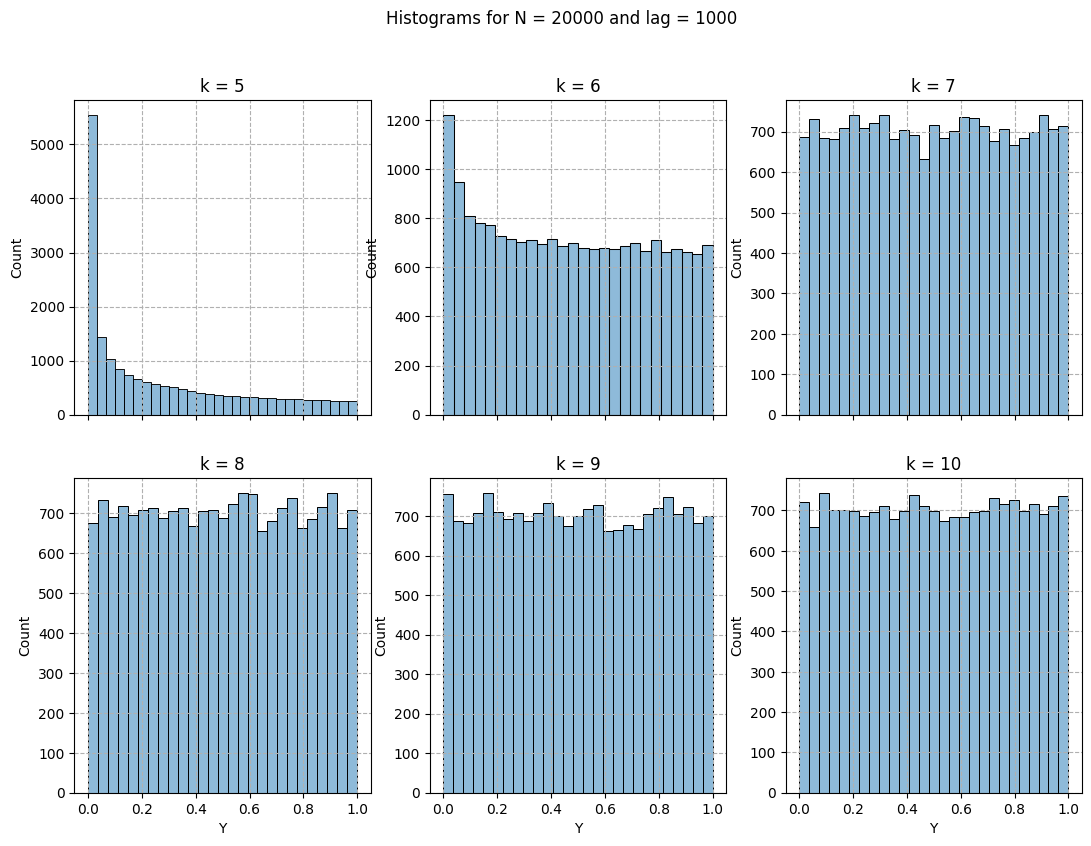

In [ ]:
ks = [5, 6, 7, 8, 9, 10]
fig, axes = plt.subplots(2, 3, figsize=(13, 9), sharex=True)
N = 20_000
lag = 1000
plt.suptitle(f"Histograms for N = {N} and lag = {lag}")

for i, ax in enumerate(axes.ravel()):
    Y = acorn2(N, k=ks[i], lag=lag)
    sns.histplot(ax=ax, data=Y, alpha=0.5)
    ax.set_title(f"k = {ks[i]}")
    # ax.set_ylabel("")
    ax.set_xlabel("Y")

#### Wnioski:

 Widzimy, że już dla $k = 7$ prawdopodobieństwa wystąpienia poszczególnych wartości są bliskie równych. Biorąc jednak pod uwagę zależność wartości $Y_n$ od $Y_{n-1}$, dopiero dla $k >= 8$ algorytm generuje liczby pseudolosowe, których rozkład przypomina $U(0,1)$.

### Analiza wydajności implementacji

In [ ]:
Ns = [1_000, 5_000, 10_000, 20_000, 50_000, 75_000, 100_000]
N = Ns[-1]
trials = 5 # number of measurements
times = np.zeros((len(Ns), 3))

for i, N in enumerate(Ns):
    times[i, 0] = timeit.timeit(f"acorn({N}, k=9, lag=1000)", setup="from __main__ import acorn", number=trials)
    times[i, 1] = timeit.timeit(f"acorn2({N}, k=9, lag=1000)", setup="from __main__ import acorn2", number=trials)
    times[i, 2] = timeit.timeit(f"np.random.rand({N})", setup="import numpy as np", number=trials)

times = times / trials

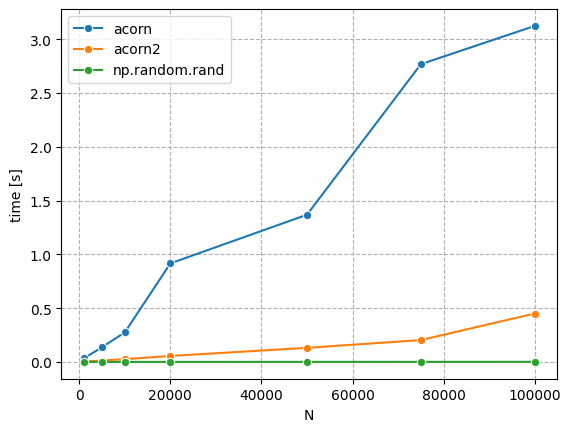

In [ ]:
sns.lineplot(x=Ns, y=times[:, 0], marker="o", label="acorn")
sns.lineplot(x=Ns, y=times[:, 1], marker="o", label="acorn2")
sns.lineplot(x=Ns, y=times[:, 2], marker="o", label="np.random.rand")
plt.xlabel("N")
plt.ylabel("time [s]");

#### Wnioski:
Widzimy, że implementacja acorn2 okazała się znacznie efektywniejsza od pierwotnej wersji acorn. Najwydajniejsza okazała się funkcja np.random.rand dostępna w module NumPy.

# Zadanie 2

W tym zadaniu sprawdzimy poprawność poznanych metod generowania rozkładu normalnego:
- Boxa-Mullera
- Marsaglia
- akceptacji i odrzucenia
- odwrotnej dystrybuanty

Następnie zaimplementujemy dwie nowe metody:
- tuzina
-zigguratu

Oraz porównamy efektywność wszytskich metod.

### Metoda Boxa-Mullera
Generuje pary niezależnych próbek z rozkładu normalnego, używając dwóch liczb losowych i przekształcając je za pomocą funkcji trygonometrycznych.

In [ ]:
def generate_box_muller_samples(n: int) -> np.ndarray:
    """
    Generate pairs of independent standard normally distributed random samples
    using the Box-Muller transform.

    Args:
        n (int): Number of pairs of samples to generate.

    Returns:
        np.ndarray: Array containing pairs of samples from N(0, 1).

    Example:
        >>> samples = generate_box_muller_samples(5)
        [[ 0.67651333 -1.57478532]
         [ 0.91721221  0.98222932]
         [-0.06063317  1.69096695]
         [ 1.95037048  0.39793897]
         [ 0.95493449  0.71561376]]

    """
    u1, u2 = np.random.uniform(0, 1, n), np.random.uniform(0, 1, n)
    z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    return np.column_stack((z1, z2))

# Example of generating 500 pairs of samples
samples = generate_box_muller_samples(500)
print(samples[:10])



[[-1.10931657  0.52995146]
 [-2.27291327  0.35204716]
 [-2.14580045  0.31852334]
 [-0.3932454   1.94684907]
 [ 1.67637469 -0.15777508]
 [-0.77140463  0.76853028]
 [ 1.4791892  -0.93497326]
 [ 0.45306088 -1.6868049 ]
 [ 1.92459197  1.2696675 ]
 [ 1.51028113 -2.07275806]]


## Metoda Marsaglia
Generuje pary niezależnych próbek z rozkładu normalnego, przekształcając liczby losowe wewnątrz jednostkowego koła.

In [ ]:
def generate_marsaglia_samples(n: int) -> np.ndarray:
    """
    Generate pairs of independent standard normally distributed random samples
    using the Marsaglia polar method.

    Args:
        n (int): Number of pairs of samples to generate.

    Returns:
        np.ndarray: Array containing pairs of samples from N(0, 1).

    Example:
        >>> samples = generate_marsaglia_samples(5)
        [[ 0.68359172  0.23154912]
         [ 0.17656907 -0.42035047]
         [-0.17585705 -0.59222521]
         [-1.07930007  1.4762214 ]
         [-0.70901591  2.24802946]]
    """
    samples = []
    while len(samples) < n:
        u1, u2 = np.random.uniform(-1, 1, 2)
        if u1**2 + u2**2 >= 1 or u1**2 + u2**2 == 0:
            continue
        samples.append([u1 * np.sqrt(-2 * np.log(u1**2 + u2**2) / (u1**2 + u2**2)), u2 * np.sqrt(-2 * np.log(u1**2 + u2**2) / (u1**2 + u2**2))])
    return np.array(samples)

# Example of generating 500 pairs of samples
samples = generate_marsaglia_samples(500)
print(samples[:10])




[[-1.4929316  -0.0385468 ]
 [ 1.75286711 -1.42683716]
 [-1.54407334  1.04096045]
 [-0.23338206  0.39758594]
 [-0.56378516  1.01901739]
 [ 0.17352209 -0.59734969]
 [ 1.43441319 -0.22744309]
 [ 1.90536544  0.84657118]
 [ 1.50824766  0.68915281]
 [ 0.49595633  1.75551498]]


## Metoda akceptacji i odrzucenia
Generuje próbki akceptując je z prawdopodobieństwem proporcjonalnym do stosunku rozkładu docelowego.

In [ ]:
def generate_rejection_sampling_samples(n: int) -> np.ndarray:
    """
    Generate samples from a standard normal distribution using the rejection sampling method.

    Args:
        n (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of generated samples from N(0, 1).

    Example:
        >>> samples = generate_rejection_sampling_samples(5)
        [-0.55048198  0.39625529  0.21990762 -2.09609915 -1.89801697]
    """
    samples = []
    while len(samples) < n:
        if np.random.uniform(0, np.exp(-0.5 * np.random.normal(0, 1)**2)) <= np.exp(-0.5 * np.random.normal(0, 1)**2):
            samples.append(np.random.normal(0, 1))
    return np.array(samples)

samples = generate_rejection_sampling_samples(1000)
print(samples[:10])

[-1.66499075 -0.05819973  0.67142775 -1.62260215  2.09680657  0.87283669
 -0.93485901 -1.30575904 -1.44482566  0.52300018]


## Metoda odwrotnej dystrybuanty
Przekształca jednolicie rozłożone próbki losowe na próbki z pożądanego rozkładu, stosując odwrotność dystrybuanty tego rozkładu.

In [ ]:
def inverse_transform_sampling(n: int) -> np.ndarray:
    """
    Generate samples from a standard normal distribution using the inverse transform sampling method.
    This method transforms uniformly distributed samples into samples that follow a specified distribution,
    in this case, the standard normal distribution.

    Args:
        n (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of samples from the standard normal distribution.

    Example:
        >>> samples = inverse_transform_sampling(5)
        [-0.17954508  1.61551912  1.70476921 -0.20355527  0.41360926]
    """
    # Generate uniform samples from 0 to 1
    uniform_samples = np.random.uniform(0, 1, n)
    # Transform these uniform samples to standard normal samples using the PPF (Percent Point Function)
    return stats.norm.ppf(uniform_samples)

samples = inverse_transform_sampling(1000)
print(samples[:10])

[ 0.04626895 -1.78920542 -0.13096442 -0.41823216  0.31360304  1.58685481
  1.38385562  0.53482205  0.74412278  2.36813059]


## Sprawdzenie poprawności dotychczas zaimplementowanych algorytmów
Poprzez porównanie gęstości empirycznych i teoretycznych

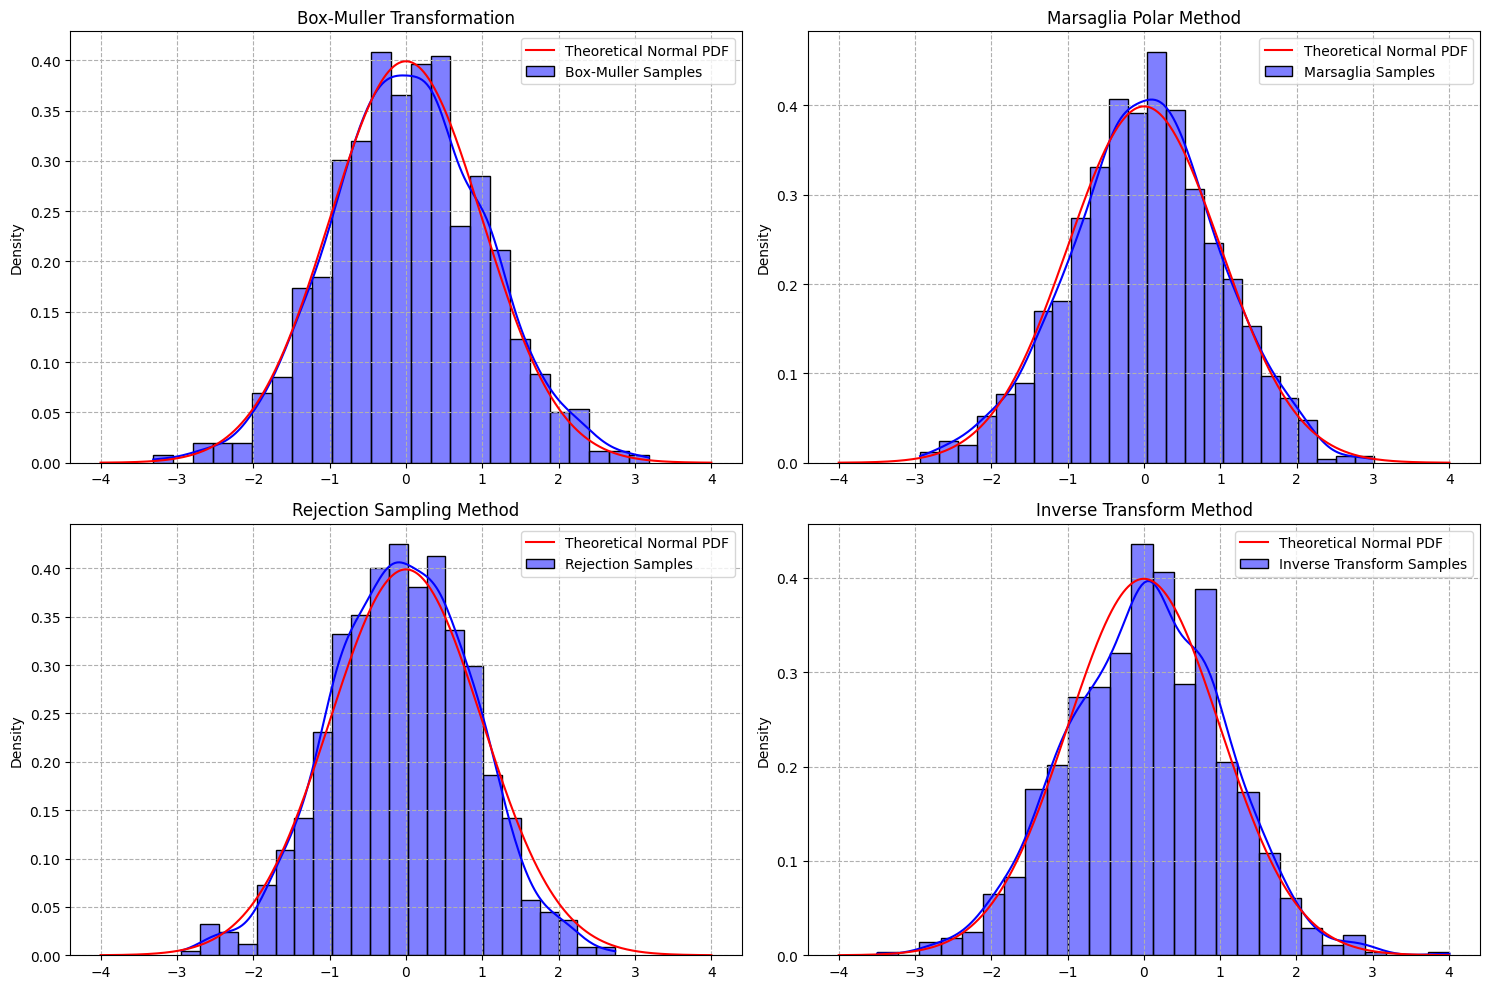

In [ ]:
def plot_distributions(n: int =1000):
    """
    Plot histograms and theoretical normal density of the samples generated using different methods.

    Args:
        n (int): Number of samples to plot for each method.

    Example:
        >>> plot_distributions(1000)
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Box-Muller
    samples = generate_box_muller_samples(n)[:, 0]
    sns.histplot(samples, stat='density', kde=True, label='Box-Muller Samples', color='blue', ax=axs[0, 0])
    x_range = np.linspace(-4, 4, 1000)
    theoretical_pdf = stats.norm.pdf(x_range, 0, 1)
    axs[0, 0].plot(x_range, theoretical_pdf, 'red', label='Theoretical Normal PDF')
    axs[0, 0].set_title('Box-Muller Transformation')
    axs[0, 0].legend()


    # Marsaglia
    samples = generate_marsaglia_samples(n)[:, 0]
    sns.histplot(samples, stat='density', kde=True, label='Marsaglia Samples', color='blue', ax=axs[0, 1])
    x_range = np.linspace(-4, 4, 1000)
    theoretical_pdf = stats.norm.pdf(x_range, 0, 1)
    axs[0, 1].plot(x_range, theoretical_pdf, 'red', label='Theoretical Normal PDF')
    axs[0, 1].set_title('Marsaglia Polar Method')
    axs[0, 1].legend()


    # Rejection sampling
    samples = generate_rejection_sampling_samples(n)
    sns.histplot(samples, stat='density', kde=True, label='Rejection Samples', color='blue', ax=axs[1, 0])
    x_range = np.linspace(-4, 4, 1000)
    theoretical_pdf = stats.norm.pdf(x_range, 0, 1)
    axs[1, 0].plot(x_range, theoretical_pdf, 'red', label='Theoretical Normal PDF')
    axs[1, 0].set_title('Rejection Sampling Method')
    axs[1, 0].legend()


    # Inverse transform
    samples = inverse_transform_sampling(n)
    sns.histplot(samples, stat='density', kde=True, label='Inverse Transform Samples', color='blue', ax=axs[1, 1])
    x_range = np.linspace(-4, 4, 1000)
    theoretical_pdf = stats.norm.pdf(x_range, 0, 1)
    axs[1, 1].plot(x_range, theoretical_pdf, 'red', label='Theoretical Normal PDF')
    axs[1, 1].set_title('Inverse Transform Method')
    axs[1, 1].legend()


    plt.tight_layout()
    plt.show()

# Plot all distributions
plot_distributions()


### Wnioski
Wszystkie cztery metody generują próbki, które dobrze pasują do teoretycznego rozkładu normalnego, co jest widoczne na histogramach. Możemy założyć że te metody poprawnie generują rozkład naturalny.



## Metoda Tuzina
Generuje próbki z rozkładu normalnego, sumując dwanaście jednolicie rozłożonych liczb losowych i odejmując od sumy 6, co daje aproksymację rozkładu normalnego.

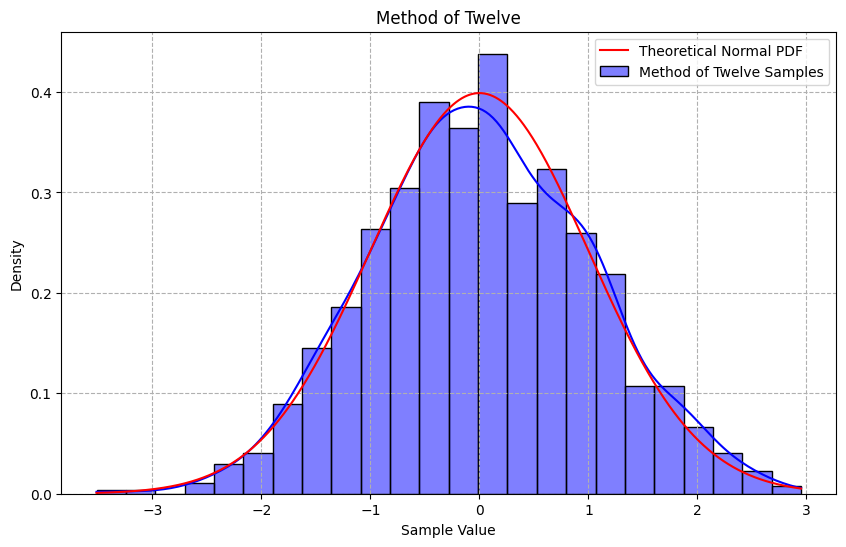

In [ ]:
def method_of_twelve(n: int) -> np.ndarray:
    """
    Generate samples from an approximately normal distribution using the method of twelve.
    This method sums twelve uniformly distributed random variables to approximate a normal distribution.

    Args:
        n (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of samples approximately from N(0, 1).

    Example:
        >>> samples = method_of_twelve(5)
        [-0.62345008 -0.75233293 -0.04262207  0.04390864  0.23887243]
    """
    # Sum twelve uniform distributions and adjust to mean 0, variance 1
    # Adjust the mean
    return np.array([sum(np.random.uniform(0, 1, 12)) for _ in range(n)]) - 6



def plot_distribution_method_of_twelve(n: int =1000):
    """
    Plot histogram and theoretical normal density of the samples generated using the method of twelve.

    Args:
        n (int): Number of samples to visualize.

    Example:
        >>> plot_distribution_method_of_twelve(1000)
    """
    samples = method_of_twelve(n)
    plt.figure(figsize=(10, 6))
    sns.histplot(samples, stat='density', kde=True, label='Method of Twelve Samples', color='blue')
    x_range = np.linspace(min(samples), max(samples), 1000)
    theoretical_pdf = stats.norm.pdf(x_range, 0, 1)
    plt.plot(x_range, theoretical_pdf, 'red', label='Theoretical Normal PDF')

    plt.xlabel('Sample Value')
    plt.ylabel('Density')
    plt.title('Method of Twelve')
    plt.legend()
    plt.show()

# Example of generating and plotting using the method of twelve
plot_distribution_method_of_twelve(1000)


Metoda tuzina generuje próbki, które dobrze pasują do teoretycznego rozkładu normalnego, co jest widoczne na histogramie.




## Metoda Ziggurat
Generuje próbki z rozkładu normalnego, dzieląc rozkład na wiele warstw (zigguratów) i wykorzystując wcześniej obliczone tabele do próbkowania z każdej warstwy.

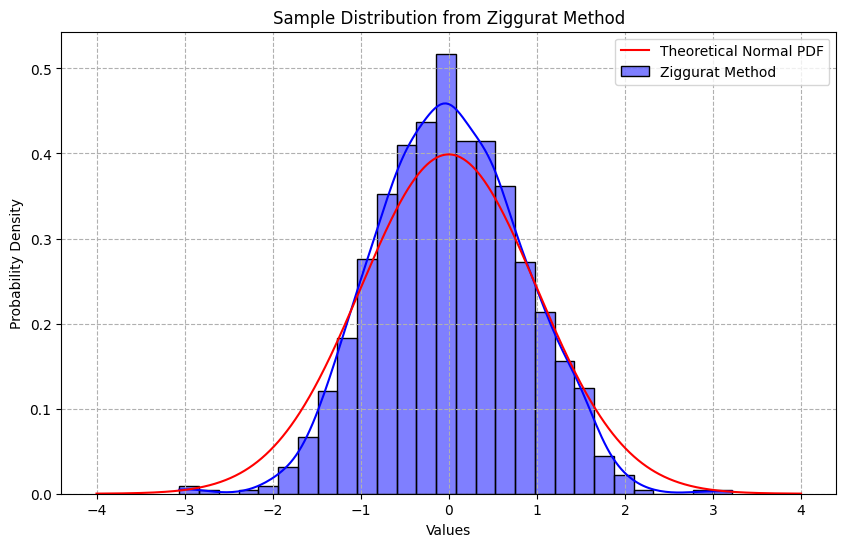

In [ ]:
def generate_ziggurat_samples(n: int) -> np.ndarray:
    """
    Generate samples from a normal distribution using the Ziggurat method.

    Args:
        n (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of samples from N(0, 1).

    Example:
        >>> samples = generate_ziggurat_samples(5)
        [ 0.92774221 -0.35528179  0.09780095 -0.82148959 -0.0458996 ]
    """
    ZIGGURAT_R = 3.442619855899 # Constant defining the boundary of the central region of the normal distribution
    ZIGGURAT_V = 9.91256303526217e-3 # Constant defining the value specified by the Ziggurat curve at the point ZIGGURAT_R

    # Initialize arrays for x and y coordinates of the Ziggurat levels
    x = np.zeros(128)
    y = np.zeros(128)
    x[0] = ZIGGURAT_R # Set first level
    y[0] = ZIGGURAT_V / np.exp(-0.5 * ZIGGURAT_R ** 2) # Calculate first level

    # Fill the x and y arrays for levels 1 to 126
    for i in range(1, 127):
        x[i] = np.sqrt(-2 * np.log(ZIGGURAT_V / x[i - 1] + np.exp(-0.5 * x[i - 1] ** 2)))
        y[i] = ZIGGURAT_V / np.exp(-0.5 * x[i] ** 2) # Calculate values for level i
    x[127] = 0.0 # Set the end value of x array

    # Initialize array for storing samples
    samples = np.zeros(n)
    for i in range(n):
        while True:
            u = 2 * np.random.uniform() - 1
            j = np.random.randint(0, 128) # Select level
            sample = u * x[j]
            if np.abs(u) < y[j]: # Acceptance condition
                samples[i] = sample
                break
            if j == 0: # Special case for level 0
                while True:
                    x_val = -np.log(np.random.uniform()) / ZIGGURAT_R
                    y_val = -np.log(np.random.uniform())
                    if y_val + y_val > x_val * x_val: # Check the tail condition
                        sample = -ZIGGURAT_R - x_val if u < 0 else ZIGGURAT_R + x_val
                        samples[i] = sample
                        break
                break
            elif y[j] + np.random.uniform() * (y[j - 1] - y[j]) < np.exp(-0.5 * x[j] * x[j]): # Additional acceptance condition
                samples[i] = sample
                break
    return samples


def plot_distribution_ziggurat(n: int = 1000):
    """
    Plot histogram and theoretical normal density of the samples generated using the Ziggurat method.

    Args:
        n (int): Number of samples to visualize.

    Example:
        >>> plot_distribution_ziggurat(1000)
    """
    samples = generate_ziggurat_samples(n)
    plt.figure(figsize=(10, 6))
    sns.histplot(samples, stat='density', kde=True, label='Ziggurat Method', color='blue')
    #plt.hist(samples, bins=30, density=True, alpha=0.75, color='blue', label='Ziggurat Samples')
    x = np.linspace(-4, 4, 1000)
    plt.plot(x, stats.norm.pdf(x), 'r-', label='Theoretical Normal PDF')
    plt.xlabel('Values')
    plt.ylabel('Probability Density')
    plt.title('Sample Distribution from Ziggurat Method')
    plt.legend()
    plt.show()

# Example of generating and plotting using the Ziggurat method
plot_distribution_ziggurat(1000)


Metoda zigguratu generuje próbki, które przypominają teoretyczny rozkład normalny, co możemy odczytać z histogramu.

## Porównanie czasów powyższych metod

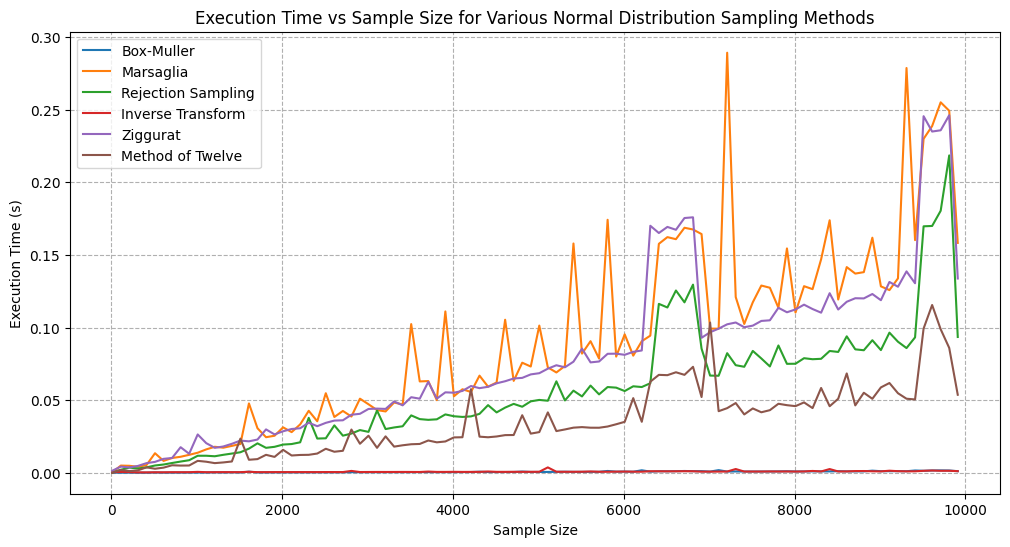

In [ ]:
methods = {
    'Box-Muller': generate_box_muller_samples,
    'Marsaglia': generate_marsaglia_samples,
    'Rejection Sampling': generate_rejection_sampling_samples,
    'Inverse Transform': inverse_transform_sampling,
    'Ziggurat': generate_ziggurat_samples,
    'Method of Twelve': method_of_twelve
}
def measure_execution_times(sample_sizes) -> dict:
    """
    Measure the execution times for various sampling methods.

    Args:
        sample_sizes (Iterable[int]): Iterable of sample sizes to test.

    Returns:
        dict: Dictionary of execution times for each method.
              Keys are method names, values are lists of execution times for each sample size.
    """
    # Initialize a dictionary to store the times for each method
    times = {method: [] for method in methods}

    # Loop through each sample size
    for size in sample_sizes:
        for method_name, method in methods.items():
            # Record the start time
            start_time = time.time()
            # Generate samples
            method(size)
            # Record the end time
            end_time = time.time()
            # Calculate the elapsed time and store it
            times[method_name].append(end_time - start_time)

    return times

def plot_execution_times(times: dict, sample_sizes):
    """
    Plot the execution times for various sampling methods.

    Args:
        times (dict): Dictionary of execution times for each method.
                      Keys are method names, values are lists of execution times for each sample size.
        sample_sizes (Iterable[int]): Iterable of sample sizes tested.
    """
    plt.figure(figsize=(12, 6))

    # Plot execution times for each method
    for method_name, execution_times in times.items():
        plt.plot(sample_sizes, execution_times, label=method_name)

    plt.xlabel('Sample Size')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time vs Sample Size for Various Normal Distribution Sampling Methods')
    plt.legend()
    plt.show()


sample_sizes = range(10, 10001, 100)
times = measure_execution_times(sample_sizes)
plot_execution_times(times, sample_sizes)


### Wnioski
Każda z powyższych metod została sprawdzona i przetestowana pod względem poprawności oraz efektywności. Możemy wyciągnąć wnioski, że każda z tych metod skutecznie generuje rozkład normalny, z różną efektywnością. Wybór metody może zależeć od konkretnych wymagań zadania, na przykład wymagań dotyczących czasu obliczeń, dokładności lub prostoty implementacji.








# Zadanie 3


####Celem zadania było obliczenie całki metodą Monte Carlo oraz zastosowanie metody redukcji wariancji do jej ponownego obliczenia i porównanie otrzymanych wyników. Rozważana była całka
$$
\int_{0}^{1} \frac{4}{1+x^2} \, dx
$$
####której wynikiem jest szacunkowa wartość liczby $ \pi $.


####Najpierw używamy metody Monte Carlo do oszacowania wartości liczby $π$, generując losowe próbki w przedziale od $0$ do $1$, a następnie obliczając średnią wartość z wyliczonych równań, co daje nam przybliżenie wartości $π$.

In [ ]:
def monte_carlo_pi(num_samples: int =10000) -> float:
    """
    Estimate the value of π using the Monte Carlo method.

    Parameters:
    num_samples (int): The number of samples to use in the Monte Carlo simulation.

    Returns:
    float: The estimated value of π.

    Example:
    >>> monte_carlo_pi()
    3.141592653589793
    """

    return np.mean(4 / (1 + np.random.uniform(0, 1, num_samples)**2))

# Test
num_samples = 10000
pi_estimate = monte_carlo_pi()
print(f"Monte Carlo estimate of π with {num_samples} samples: {pi_estimate}")

Monte Carlo estimate of π with 10000 samples: 3.1434213889802227


####Następnie wykorzystano metodę odbić lustrzanych w celu zwiększenia dokładności otrzymanych wyników.

Metoda odbić lustrzanych jest techniką redukcji wariancji. Polega ona na tym, że dla każdej próby losowej rozważana jest również próba przeciwstawna - korelacja prób jest równa $-1$. Przyjęcie dwóch zbiorów wartości funkcji skutkuje zmniejszeniem wariancji i poprawieniem precyzji.

In [ ]:
def monte_carlo_pi_antithetic(num_samples: int =10000) -> float:
    """
    Estimate the value of π using the Monte Carlo method with Antithetic Variates.

    Parameters:
    num_samples (int): The number of samples to use in the Monte Carlo simulation.
                       This should be an even number as it will be divided into two sets of samples.

    Returns:
    float: The estimated value of π using the Antithetic Variates method.

    Example:
    >>> monte_carlo_pi_antithetic()
    3.141592653589793
    """
    samples = np.random.uniform(0, 1, num_samples // 2)
    combined_samples = np.concatenate([samples, 1 - samples])
    return np.mean( 4 / (1 + combined_samples**2))

#Test
num_samples = 10000
pi_estimate_antithetic = monte_carlo_pi_antithetic()
print(f"Antithetic Variates estimate of π with {num_samples} samples: {pi_estimate_antithetic}")

Antithetic Variates estimate of π with 10000 samples: 3.140845102277456


####Ostatnim krokiem jest wygenerowanie wykresu błędu względem ilości  dla obu metod.

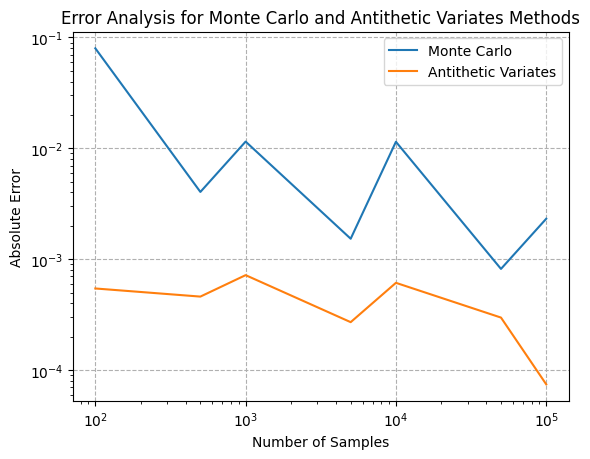

In [ ]:
def calculate_errors(num_samples_list: typing.List[int], true_value: float = np.pi) -> typing.Tuple[typing.List[float], typing.List[float]]:
    """
    Calculate the absolute errors of π estimates for different numbers of samples.

    Parameters:
    num_samples_list (list of int): A list of different numbers of samples to use in the simulations.
    true_value (float, optional): The true value of π for error calculation. Default is numpy's π.

    Returns:
    tuple of lists: Two lists containing the absolute errors for the standard Monte Carlo method
                    and the Antithetic Variates method, respectively.

    Example:
    >>> num_samples_list = [100, 500, 1000, 5000, 10000, 50000, 100000]
    >>> mc_errors, antithetic_errors = calculate_errors(num_samples_list)
    >>> mc_errors
    [0.031415926535897934, 0.006283185307179586, 0.0031415926535897933, 0.0012566370614359173, 0.0006283185307179586, 0.00012566370614359174, 0.00006283185307179587]
    >>> antithetic_errors
    [0.015707963267948967, 0.0031415926535897933, 0.0015707963267948967, 0.0006283185307179586, 0.0003141592653589793, 0.00006283185307179587, 0.00003141592653589793]
    """
    mc_errors = []
    antithetic_errors = []

    for num_samples in num_samples_list:
        mc_estimate = monte_carlo_pi(num_samples)
        mc_errors.append(abs(mc_estimate - true_value))

        antithetic_estimate = monte_carlo_pi_antithetic(num_samples)
        antithetic_errors.append(abs(antithetic_estimate - true_value))

    return mc_errors, antithetic_errors

# Test
num_samples_list = [100, 500, 1000, 5000, 10000, 50000, 100000]
mc_errors, antithetic_errors = calculate_errors(num_samples_list)

plt.plot(num_samples_list, mc_errors, label='Monte Carlo')
plt.plot(num_samples_list, antithetic_errors, label='Antithetic Variates')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples')
plt.ylabel('Absolute Error')
plt.legend()
plt.title('Error Analysis for Monte Carlo and Antithetic Variates Methods')
plt.show()

#### Wnioski z wykresu:

1. Trend malejący: Dla obu metod błąd bezwzględny maleje wraz ze wzrostem liczby próbek. Jest to zgodne z oczekiwaniami, ponieważ więcej próbek powinno prowadzić do dokładniejszego oszacowania wartości $π$.

2. Lepsza dokładność metody Antithetic Variates: W większości przypadków, metoda Antithetic Variates ma niższy błąd bezwzględny w porównaniu do standardowej metody Monte Carlo przy tej samej liczbie próbek. Świadczy to o skuteczności metody odbić lustrzanych w redukcji wariancji oszacowań.

3. Stabilność metody Antithetic Variates: Linia błędu dla metody Antithetic Variates jest bardziej stabilna i mniej podatna na skoki w porównaniu do standardowej metody Monte Carlo. Oznacza to, że metoda Antithetic Variates daje bardziej stabilne i wiarygodne wyniki, szczególnie przy mniejszej liczbie próbek.

Podsumowując Metoda Antithetic Variates jest skuteczniejsza w redukcji błędu i oferuje większą stabilność w oszacowaniach liczby $π$ niż standardowa metoda Monte Carlo, zwłaszcza przy ograniczonej liczbie próbek.


#Zadanie 4

####Celem zadania jest symulacyjne sprawdzenie stwierdzeń dotyczących warunkowej wartości oczekiwanej.

Pierwszym z nich jest stwierdzenie:

Jeśli $X, Y$ są zmiennymi niezależnymi, a $\mathbb{E}(Y) = 0$, to dla $Z = XY + \sin X$ zachodzi $\mathbb{E}(Z|X) = \sin X$.

Jako przykład wybrano zmienne niezależne z rozkładu normalnego $ X, Y \sim \mathcal{N}(0,\,1)$. Następnie skonstruowano zmienną $Z$ i obliczono jej wartość oczekiwaną pod warunkiem $X$. Na wykresie porównano wysymulowane wartości z wartościami estymowanymi oraz teoretycznymi wartości oczekiwanej.

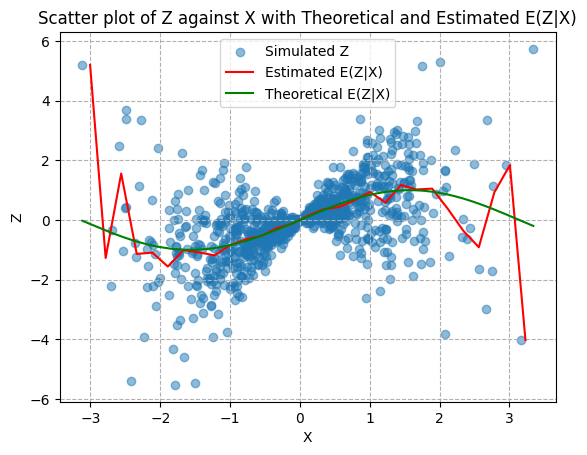

In [ ]:
def simulate_independent_variables(n: int) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate independent normal variables X and Y and compute Z = XY + sin(X).

    Parameters:
    n (int): Number of samples to generate.

    Returns:
    tuple of np.ndarray: Arrays of X, Y, and Z.

    Example:
    >>> X, Y, Z = simulate_independent_variables(1000)
    """
    X = np.random.normal(0, 1, n)
    Y = np.random.normal(0, 1, n)
    Z = X * Y + np.sin(X)
    return X, Y, Z

def plot_estimated_vs_theoretical(X: np.ndarray, Z: np.ndarray):
    """
    Create a scatter plot of simulated Z against X and overlay the theoretical and estimated E(Z|X).

    Parameters:
    X (np.ndarray): Array of X values.
    Z (np.ndarray): Array of Z values.

    Example:
    >>> X, Y, Z = simulate_independent_variables(1000)
    >>> plot_estimated_vs_theoretical(X, Z)
    """
    plt.scatter(X, Z, alpha=0.5, label='Simulated Z')

    # Estimation using binning
    bins = np.linspace(np.min(X), np.max(X), 30)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    digitized = np.digitize(X, bins)

    bin_means = []
    for i in range(1, len(bins)):
        bin_values = Z[digitized == i]
        if len(bin_values) > 0:
            bin_means.append(bin_values.mean())
        else:
            bin_means.append(np.nan)  # or handle it in another appropriate way

    bin_means = np.array(bin_means)

    plt.plot(bin_centers, bin_means, label='Estimated E(Z|X)', color='red')
    plt.plot(np.sort(X), np.sin(np.sort(X)), label='Theoretical E(Z|X)', color='green')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('Scatter plot of Z against X with Theoretical and Estimated E(Z|X)')
    plt.legend()
    plt.show()

# Example usage
n_samples = 1000
X, Y, Z = simulate_independent_variables(n_samples)
plot_estimated_vs_theoretical(X, Z)

#### Wnioski:

1. Symulacja zmiennych niezależnych: Funkcja simulate_independent_variables symuluje dwie niezależne zmienne normalne $X$ i $Y$, a następnie oblicza zmienną $Z$ jako $Z = XY + sin(X)$. Dzięki tej funkcji możemy zbadać zależność między $X$ a $Z$, gdzie $Z$ jest funkcją zarówno $X$, jak i $Y$.

2. Wykres teoretyczny vs oszacowany: Wykres pokazuje zależność między $X$ a $Z$, wraz z teoretyczną wartością $E(Z|X)$ (zielona linia) oraz oszacowaną wartością $E(Z|X)$ (czerwona linia) uzyskaną poprzez średnie wartości w poszczególnych binach $X$. Teoretyczna wartość $E(Z|X) = sin(X)$ wynika z założeń, ponieważ $E(Y) = 0$ i zmienne $X$ i $Y$ są niezależne.

3. Dopasowanie oszacowanej wartości: Czerwona linia pokazuje, że oszacowana wartość $E(Z|X)$ dobrze dopasowuje się do teoretycznej wartości, co wskazuje na poprawność symulacji oraz metody estymacji użytej w funkcji plot_estimated_vs_theoretical.


####Przejdźmy do kolejnego stwierdzenia odnoszącego się do procesu Poissona.
Zbadano czy, wartość oczekiwana liczby klientów przybyłych do sklepu w chwili $t$ pod warunkiem, że w chwili $T$ liczba klientów w sklepie wyniosła $N_T$, wynosi $t N_T / T$.

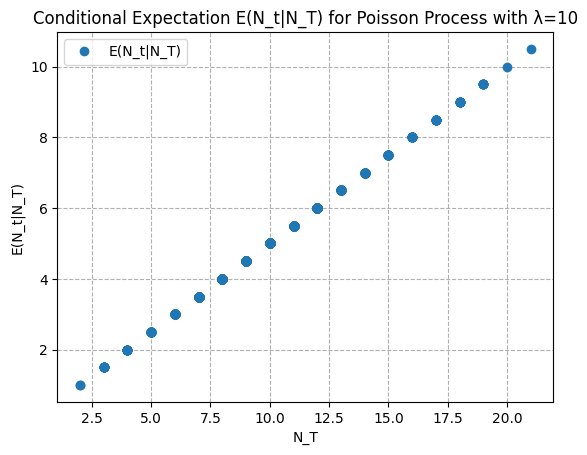

In [ ]:
def simulate_poisson_process(lam: float, T: float, num_simulations: int) -> typing.List[np.ndarray]:
    """
    Simulate a Poisson process with intensity lambda up to time T.

    Parameters:
    lam (float): Intensity of the Poisson process.
    T (float): Upper limit of time.
    num_simulations (int): Number of simulations to run.

    Returns:
    list of np.ndarray: List of arrays representing the Poisson process for each simulation.

    Example:
    >>> processes = simulate_poisson_process(10, 1, 5)
    """
    return [np.random.poisson(lam * np.linspace(0, T, int(T * 100))) for _ in range(num_simulations)]

def plot_conditional_expectation(lam: float, T: float, t: float, num_simulations: int):
    """
    Plot the conditional expectation E(N_t|N_T) for a Poisson process.

    Parameters:
    lam (float): Intensity of the Poisson process.
    T (float): Upper limit of time.
    t (float): Time at which to calculate the conditional expectation.
    num_simulations (int): Number of simulations to run.

    Example:
    >>> plot_conditional_expectation(10, 1, 0.5, 5)
    """
    processes = simulate_poisson_process(lam, T, num_simulations)
    NT_values = [process[-1] for process in processes]
    conditional_expectations = [nt * t / T for nt in NT_values]

    plt.plot(NT_values, conditional_expectations, 'o', label=f'E(N_t|N_T)')
    plt.xlabel('N_T')
    plt.ylabel(f'E(N_t|N_T)')
    plt.title(f'Conditional Expectation E(N_t|N_T) for Poisson Process with λ={lam}')
    plt.legend()
    plt.show()

# Example usage
lam = 10
T = 1
t = 0.5
num_simulations = 1000
plot_conditional_expectation(lam, T, t, num_simulations)

#### Wnioski:

1. Symulacja procesu Poissona: Funkcja simulate_poisson_process symuluje proces Poissona o intensywności $λ$ do czasu $T$. Każda symulacja generuje proces Poissona, który jest następnie używany do analizy warunkowej wartości oczekiwanej.

2. Wykres warunkowej wartości oczekiwanej: Wykres przedstawia zależność między wartością procesu Poissona $N_T$ w chwili $T$ a warunkową wartością oczekiwaną $E(N_t|N_T)$ w chwili t. Zależność ta jest liniowa i pokazuje, że warunkowa wartość oczekiwana w chwili $t$ jest proporcjonalna do wartości procesu w chwili $T$, co jest zgodne z teorią procesu Poissona.

3. Potwierdzenie teorii: Wartości na wykresie zgadzają się z teoretycznymi oczekiwaniami, że $E(N_t|N_T) = (t/T) * N_T$, co potwierdza poprawność symulacji i estymacji.


####Przejdźmy do ostatniego stwierdzenia odnoszącego się do procesu Poissona.

 Zbadano czy, wartość oczekiwana liczby klientów przybyłych do sklepu w chwili $t$ pod warunkiem, że w chwili $s$ liczba klientów w sklepie wyniosła $N_s$, wynosi $N_s + \lambda (t-s)$

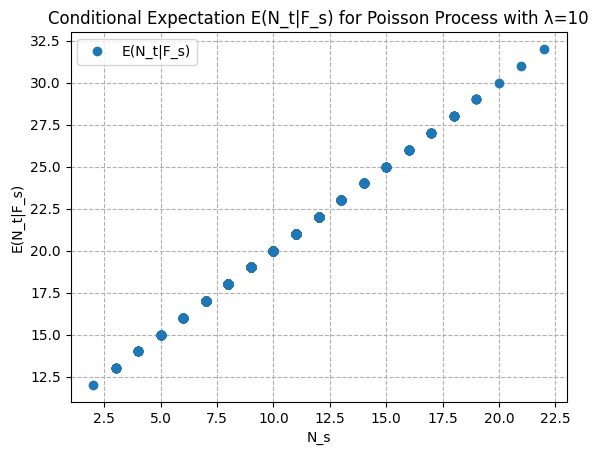

In [ ]:
def simulate_poisson_process_to_t(lam: float, t: float, num_simulations: int) -> typing.List[np.ndarray]:
    """
    Simulate a Poisson process with intensity lambda up to time t.

    Parameters:
    lam (float): Intensity of the Poisson process.
    t (float): Upper limit of time.
    num_simulations (int): Number of simulations to run.

    Returns:
    list of np.ndarray: List of arrays representing the Poisson process for each simulation.

    Example:
    >>> processes = simulate_poisson_process_to_t(10, 2, 5)
    """
    return [np.random.poisson(lam * np.linspace(0, t, int(t * 100))) for _ in range(num_simulations)]

def plot_conditional_expectation_fs(lam: float, s: float, t: float, num_simulations: int):
    """
    Plot the conditional expectation E(N_t|F_s) for a Poisson process.

    Parameters:
    lam (float): Intensity of the Poisson process.
    s (float): Time s.
    t (float): Time t.
    num_simulations (int): Number of simulations to run.

    Example:
    >>> plot_conditional_expectation_fs(10, 1, 2, 5)
    """
    processes = simulate_poisson_process_to_t(lam, t, num_simulations)
    Ns_values = [process[int(s * 100)] for process in processes]
    Nt_estimates = [ns + lam * (t - s) for ns in Ns_values]

    plt.plot(Ns_values, Nt_estimates, 'o', label=f'E(N_t|F_s)')
    plt.xlabel('N_s')
    plt.ylabel(f'E(N_t|F_s)')
    plt.title(f'Conditional Expectation E(N_t|F_s) for Poisson Process with λ={lam}')
    plt.legend()
    plt.show()

# Example usage
lam = 10
s = 1
t = 2
num_simulations = 1000
plot_conditional_expectation_fs(lam, s, t, num_simulations)

#### Wnioski:

 1. Symulacja procesu Poissona do czasu $t$: Funkcja simulate_poisson_process_to_t symuluje proces Poissona o intensywności $λ$ do czasu $t$. Funkcja plot_conditional_expectation_fs oblicza warunkową wartość oczekiwaną $E(N_t|F_s)$ dla procesu Poissona.

2. Wykres warunkowej wartości oczekiwanej: Wykres przedstawia zależność między wartością procesu Poissona $N_s$ w chwili $s$ a warunkową wartością oczekiwaną $E(N_t|F_s)$ w chwili $t$. Zależność ta pokazuje, że wartość oczekiwana w chwili $t$ jest sumą wartości w chwili $s$ i oczekiwanej liczby zdarzeń w przedziale $(s, t]$, co wynosi $λ(t - s)$.

3. Potwierdzenie teorii: Wartości na wykresie zgadzają się z teoretycznymi oczekiwaniami, że E(N_t|F_s) = N_s + λ(t - s), co potwierdza poprawność symulacji i estymacji. Symulacje wykazują zgodność z teoretycznymi wartościami, potwierdzając poprawność modelu procesu Poissona.


#Zadanie 5


####Proces ruiny
to termin, który opisuje sytuację, w której zasoby finansowe firmy ubezpieczeniowej stają się niewystarczające do pokrycia jej zobowiązań, prowadząc do jej bankructwa. Analiza tego procesu obejmuje badanie prawdopodobieństwa ruiny oraz dynamiki przepływów gotówkowych. Kluczowym aspektem jest modelowanie i przewidywanie przyszłych strat, aby zrozumieć i minimalizować ryzyko upadłości.

Skupimy się na modelu Cramera-Lundberga:
$$ X_t = u + ct - ∑^{N_t}_{i=0} ξ_i $$


Zmienne:

- $c$ - stopa składki

- $u$ - kapitał początkowy

- $η$ - parametr szybkości rozkładu wykładniczego $ξ_i$
  $(Eξ_i = η)$

- $λ$ - intensywność procesu Poissona $N_t$


####Model Cramera-Lundberga:

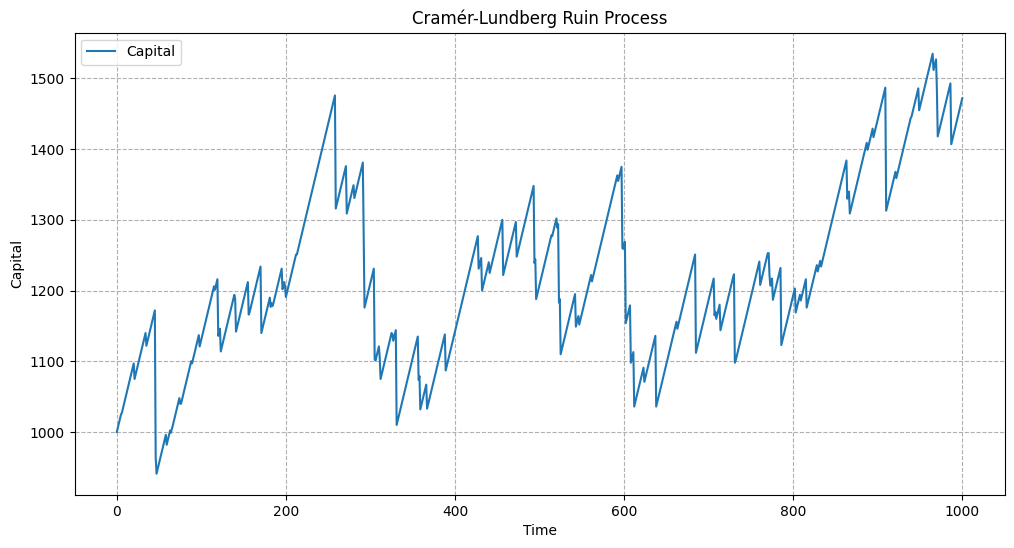

In [ ]:
# Cramér-Lundberg ruin process
u = 1000  # initial capital
premium_rate = 5  # premium rate
lambd = 0.1  # rate of claims
average_claim_size = 50  # average claim size
time_horizon = 1000  # simulation time

# Generate random events related to claims
np.random.seed(42)
num_claims = np.random.poisson(lambd * time_horizon)
claim_times = np.random.uniform(0, time_horizon, num_claims)
claim_sizes = np.random.exponential(average_claim_size, num_claims)

# Sort claim events by time
sorted_indices = np.argsort(claim_times)
claim_times = claim_times[sorted_indices]
claim_sizes = claim_sizes[sorted_indices]

# Ruin process
time_points = np.arange(0, time_horizon + 1, 1)
capital = np.zeros_like(time_points)
capital[0] = u

claim_index = 0
for t in range(1, len(time_points)):
    capital[t] = capital[t - 1] + premium_rate
    if claim_index < num_claims and claim_times[claim_index] <= time_points[t]:
        capital[t] -= claim_sizes[claim_index]
        claim_index += 1

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_points, capital, label='Capital')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.title('Cramér-Lundberg Ruin Process')
plt.legend()
plt.show()


Funkcje prawdopodobieństwa ruiny, dla różnych wartości $c$ i różnych wartości $u$.

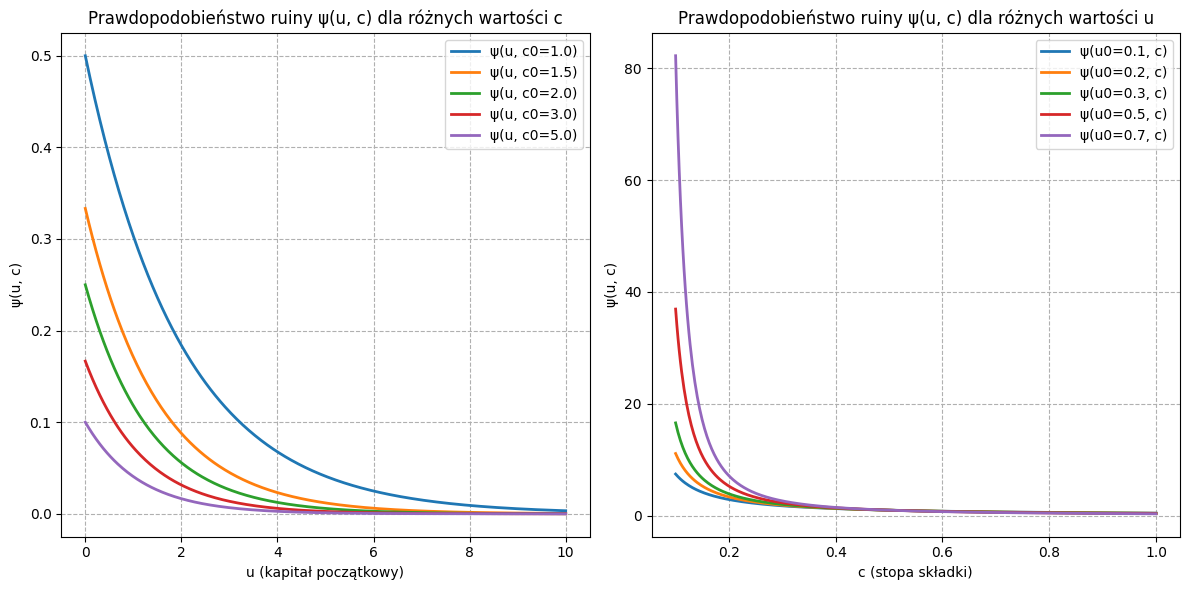

In [ ]:
eta = 1.0
lambd = 0.5

# Funkcja prawdopodobieństawa ruiny
def psi(u: float, c: float, eta: float = 1.0, lambd: float= 0.5) -> float:
    """
    Calculates the ruin probability in the Cramér-Lundberg model.

    Parameters:
    u (float): Initial capital (u ≥ 0)
    c (float): Premium rate (c > 0)
    eta (float): Rate parameter of the exponential distribution of ξ_i (η > 0)
    lambd (float): Intensity of the Poisson process N_t (λ > 0)

    Returns:
    float: Ruin probability ψ(u, c)

    Example usage:
    >>> psi(10, 1.0, 1.0, 0.5)
    0.01831563888873418
    """
    # Calculate the ruin probability
    return (eta * lambd / c) * np.exp(-(1 - lambd / (c * eta)) * u)

# u and c values
u_values = np.linspace(0, 10, 400)  # Zwiększony zakres dla u do 20
c_values = np.linspace(0.1, 1, 400)

# u_0 and c_0 fixed values
c_values_fixed = [1.0, 1.5, 2.0, 3.0, 5.0]
u_values_fixed = [0.1, 0.2, 0.3, 0.5, 0.7]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ψ(u, c) for fixed c
for c0 in c_values_fixed:
    psi_u_c0 = psi(u_values, c0, eta, lambd)
    axes[0].plot(u_values, psi_u_c0, label=f'ψ(u, c0={c0})', linewidth=2)

axes[0].set_title('Prawdopodobieństwo ruiny ψ(u, c) dla różnych wartości c')
axes[0].set_xlabel('u (kapitał początkowy)')
axes[0].set_ylabel('ψ(u, c)')
axes[0].legend()

# dla ψ(u, c) for fixed u
for u0 in u_values_fixed:
    psi_u0_c = psi(u0, c_values, eta, lambd)
    axes[1].plot(c_values, psi_u0_c, label=f'ψ(u0={u0}, c)', linewidth=2)

axes[1].set_title('Prawdopodobieństwo ruiny ψ(u, c) dla różnych wartości u')
axes[1].set_xlabel('c (stopa składki)')
axes[1].set_ylabel('ψ(u, c)')
axes[1].legend()

plt.tight_layout()
plt.show()


Wykres dla funkcji odwrotnej.

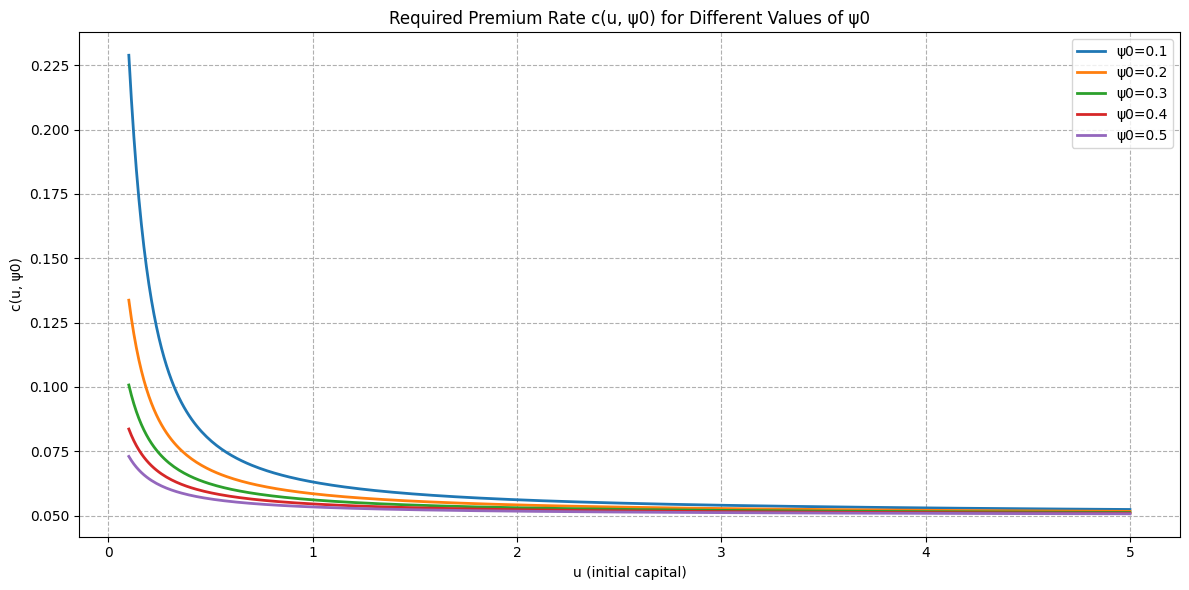

In [65]:

# Inverse ruin probability function
def c_inverse(u: float, psi0: float, eta: float =0.1, lambd: float =0.5) -> float:
    """
    Calculates the required premium rate c for given initial capital u and ruin probability ψ0.

    Parameters:
    u (float): Initial capital (u ≥ 0)
    psi0 (float): Desired ruin probability (0 < ψ0 < 1)
    eta (float): Rate parameter of the exponential distribution of ξ_i (η > 0)
    lambd (float): Intensity of the Poisson process N_t (λ > 0)

    Returns:
    float: Required premium rate c(u, ψ0)

    Example usage:
    >>> c_inverse(10, 0.3)
    1.4753940640684104

    """
    # Calculate the required premium rate
    return (lambd * u) / np.real(lambertw((psi0 * u * np.exp(u / eta)) / eta))

# u values
u_values = np.linspace(0.1, 5, 400)  # Range of u values

# Fixed psi0 values
psi0_values_fixed = [0.1, 0.2, 0.3, 0.4, 0.5]

# Plotting
plt.figure(figsize=(12, 6))

# ψ(u, c) for fixed ψ0
for psi0 in psi0_values_fixed:
    c_u_psi0 = [c_inverse(u, psi0, eta, lambd) for u in u_values]
    plt.plot(u_values, c_u_psi0, label=f'ψ0={psi0}', linewidth=2)

plt.title('Required Premium Rate c(u, ψ0) for Different Values of ψ0')
plt.xlabel('u (initial capital)')
plt.ylabel('c(u, ψ0)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#  Generating a sample of data from a normal distribution
np.random.seed(0)
sample_data = np.random.normal(0, 1, 1000)

# Kolmogorov-Smirnov test for goodness of fit to a normal distribution
statistic, p_value = stats.kstest(sample_data, 'norm')

print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value}")


KS Statistic: 0.03737519429804048
P-value: 0.11930823166569182


### Wnioski
Do określenia istotności statystycznej używa się progu wartości p 0.05. W tym przypadku, wartość p wynosząca około 0.1193 jest większa niż 0.05.
Ponieważ wartość p jest większa niż 0.05, nie mamy podstaw do odrzucenia hipotezy zerowej. Oznacza to, że nie ma wystarczających dowodów, aby stwierdzić, że dane próbki nie pochodzą z rozkładu normalnego.

Test Kołmogorowa-Smirnowa wskazuje, że dane próbki wygenerowane z rozkładu normalnego nie odbiegają istotnie od oczekiwanego rozkładu normalnego, co potwierdzają wartości statystyki KS i wartości p. W konsekwencji możemy przyjąć, że dane próbki pochodzą z rozkładu normalnego.

# Zadanie 6

#### Celem zadania była weryfikacja praw arcusa sinusa.

#### Pierwsze prawo arcusa sinusa: czas spędzony przez proces Wienera powyżej osi OX na odcinku [0,1] ma rozkład arcusa sinusa.

#### Drugie prawo arcusa sinusa: Ostatni moment uderzenia procesu Wienera na odicnku [0,1] w oś OX ma rozkład arcusa sinusa.

#### Trzecie prawo arcusa sinusa: Moment osiągnięcia maksymalnej wartości przez proces Wienera na odcinku [0,1] ma rozkład arcusa sinusa.

Definiujemy funkcję generującą proces Wienera oraz funkcje gęstości i dystrybuanty rozkładu arcusa sinusa.

In [ ]:
def W(t:float, dt:float=1e-4) -> np.array:
    """ Generates trajectory of Wiener Proccess.

    Parameters:
    t(float) - time
    dt(float) - (default 1e-4)

    Returns:
    np.array: trajectory of Wiener Proccess

    Example:
    >>> W(5)
    array([0.        , 0.01556342, 0.00663036, ..., 2.13422048, 2.13954468,
       2.12184202])
    """
    N = int(round(t / dt))
    X = np.cumsum(np.sqrt(dt) * np.random.randn(N-1))
    return np.hstack((0, X))

In [ ]:
def arcsin_pdf(x:float) -> float:
    """ Calculates arcsin pdf value for given point.

    Parameters:
    x(float) - point

    Returns:
    float: arcsin pdf value for given point

    Example:
    >>> arcsin_pdf(0.5)
    0.63661977
    """
    if 0 < x < 1:
        return 1 / (np.pi * np.sqrt(x * (1 - x)))
    else:
        return 0

arcsin_pdf = np.vectorize(arcsin_pdf)

In [ ]:
def arcsin_cdf(x:float) -> float:
    """ Calculates arcsin cdf value for given point.

    Parameters:
    x(float) - point

    Returns:
    float: arcsin cdf value for given point

    Example:
    >>> arcsin_cdf(0.3)
    0.36901012
    """
    if x < 0:
        return 0
    elif x > 1:
        return 1
    else:
        return 2/np.pi * np.arcsin(np.sqrt(x))

arcsin_cdf = np.vectorize(arcsin_cdf)

W pętli wyznaczamy poszukiwane wartości.

In [ ]:
dt = 1e-4
M = 1000
Tpluss = np.zeros(M)
Ls = np.zeros(M)
Wms = np.zeros(M)

for i in range(M):
    X = W(1, dt=dt)
    Tplus = np.sum(X > 0) * dt
    Tpluss[i] = Tplus
    L = np.where((X[:-1] * X[1:]) <= 0)[0][-1] * dt
    Ls[i] = L
    Wm = np.argmax(X) * dt
    Wms[i] = Wm

Następnie porównujemy otrzymane histogramy z wykresem gęstości rozkładu arcusa sinusa, by zweryfikować poprawność symulacji.

In [ ]:
x_axis = np.linspace(0,1,100)
theoretical_pdf = np.linspace(0,1,100)
for i in range(len(theoretical_pdf)):
    theoretical_pdf[i] = arcsin_pdf(x_axis[i])

Text(0.5, 0, 'values')

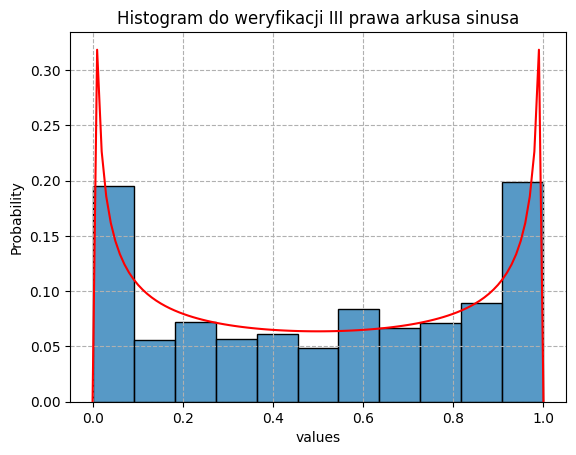

In [ ]:
sns.histplot(Wms, stat="probability")
plt.plot(x_axis, theoretical_pdf/10, 'r') #divided by 10 to make it easier to read (high values on edges)
plt.title("Histogram do weryfikacji III prawa arkusa sinusa")
plt.xlabel("values")

Text(0.5, 0, 'values')

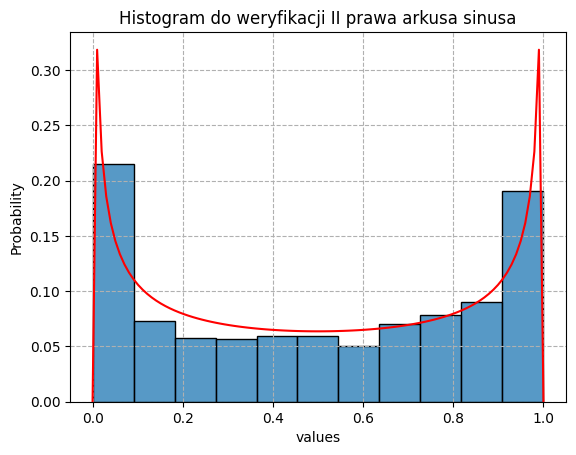

In [ ]:
plt.plot(x_axis, theoretical_pdf/10, 'r') #divided by 10 to make it easier to read (high values on edges)
sns.histplot(Ls,stat="probability")
plt.title("Histogram do weryfikacji II prawa arkusa sinusa")
plt.xlabel("values")

Text(0.5, 0, 'values')

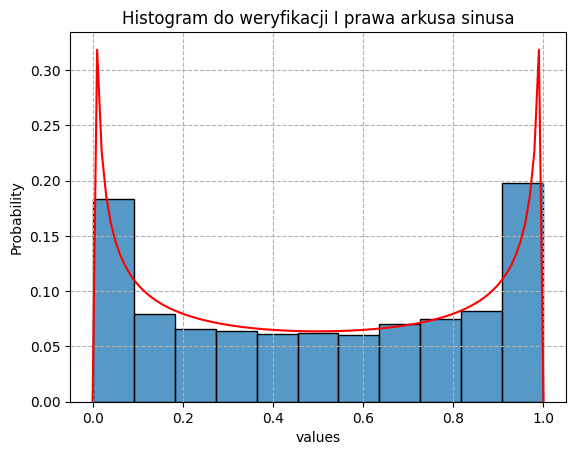

In [ ]:
sns.histplot(Tpluss, stat="probability")
plt.plot(x_axis, theoretical_pdf/10, 'r') #divided by 10 to make it easier to read (high values on edges)
plt.title("Histogram do weryfikacji I prawa arkusa sinusa")
plt.xlabel("values")

Następnie porównujemy dystrybuanty empiryczne z uzyskanych próbek wraz z dystrybuantą teoretyczną rozkładu arcusa sinusa,

In [ ]:
x_axis = np.linspace(0,1,1000)
theoretical_cdf = np.linspace(0,1,1000)
for i in range(len(theoretical_cdf)):
    theoretical_cdf[i] = arcsin_cdf(x_axis[i])

Text(0.5, 0, 'values')

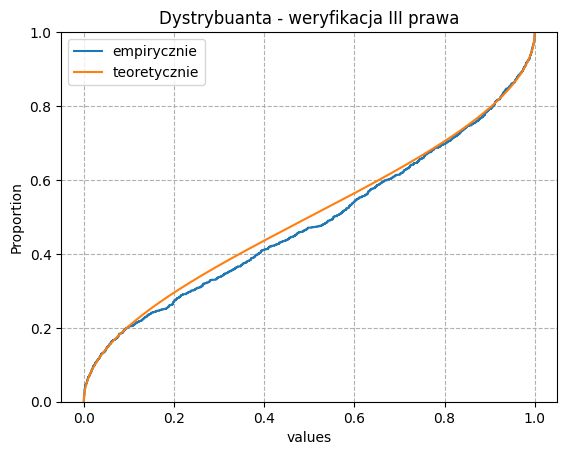

In [ ]:
plt.title("Dystrybuanta - weryfikacja III prawa")
sns.ecdfplot(Wms, label = "empirycznie")
plt.plot (x_axis, theoretical_cdf, label = "teoretycznie")
plt.legend()
plt.xlabel("values")

Text(0.5, 0, 'values')

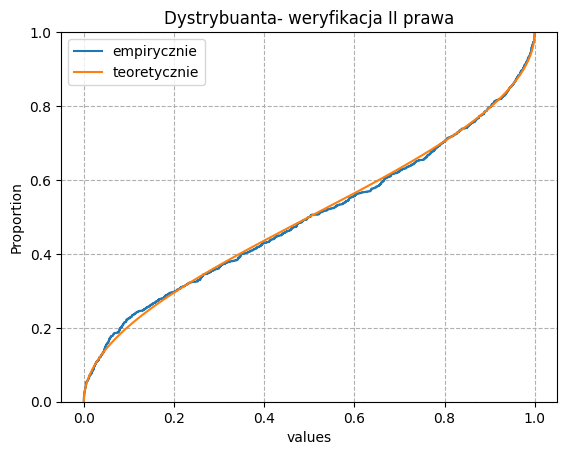

In [ ]:
plt.title("Dystrybuanta- weryfikacja II prawa")
sns.ecdfplot(Ls, label = "empirycznie")
plt.plot(x_axis, theoretical_cdf, label = "teoretycznie")
plt.legend()
plt.xlabel("values")

Text(0.5, 0, 'values')

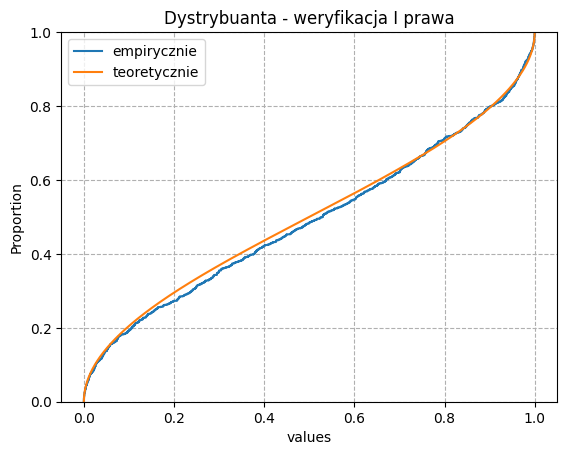

In [ ]:
plt.title("Dystrybuanta - weryfikacja I prawa")
sns.ecdfplot(Tpluss, label = "empirycznie")
plt.plot(x_axis, theoretical_cdf, label = "teoretycznie")
plt.legend()
plt.xlabel("values")

#### Wnioski:
Porównanie zarówno histogramów otrzymanych próbek do gęstości teoretycznej rozkładu arcusa sinusa oraz dystrybuant empirycznych do dystrybuanty teoretycznej wykazały zgodność dla wszystkich trzech praw arcusa sinusa.